In [1]:
import os
# import drjit
gpu_num = 1 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sionna
import tensorflow as tf
import pickle
import jammer
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')

from jammer.simulation_model import *
from jammer.utils import *
import jammer.simulation_model as sim
from tensorflow.python.keras.losses import MeanAbsoluteError, MeanSquaredError, BinaryCrossentropy

In [2]:
sim.EBN0_DB_MIN = -10
sim.EBN0_DB_MAX = 15
# sim.NUM_SNR_POINTS = 10
# sim.BATCH_SIZE = 12
# sim.MAX_MC_ITER = 15
sim.NUM_SNR_POINTS = 26
sim.BATCH_SIZE = 1024
sim.MAX_MC_ITER = 500
# sim.BATCH_SIZE = 512
# sim.MAX_MC_ITER = 1500
sim.ebno_dbs = np.linspace(sim.EBN0_DB_MIN, sim.EBN0_DB_MAX, sim.NUM_SNR_POINTS)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -10.0 | 1.6565e-01 | 1.0000e+00 |   521097707 |  3145728000 |       768000 |      768000 |       740.9 |reached max iter       
     -9.0 | 1.2985e-01 | 1.0000e+00 |   408463136 |  3145728000 |       768000 |      768000 |       728.7 |reached max iter       
     -8.0 | 9.7088e-02 | 1.0000e+00 |   305411362 |  3145728000 |       768000 |      768000 |       731.3 |reached max iter       
     -7.0 | 6.8792e-02 | 1.0000e+00 |   216400309 |  3145728000 |       768000 |      768000 |       737.3 |reached max iter       
     -6.0 | 4.5838e-02 | 1.0000e+00 |   144193199 |  3145728000 |       768000 |      768000 |       734.4 |reached max iter       
     -5.0 | 2.8491e-02 | 1.0000e+00 |    89625265 |  3145728000 |       768000 |     

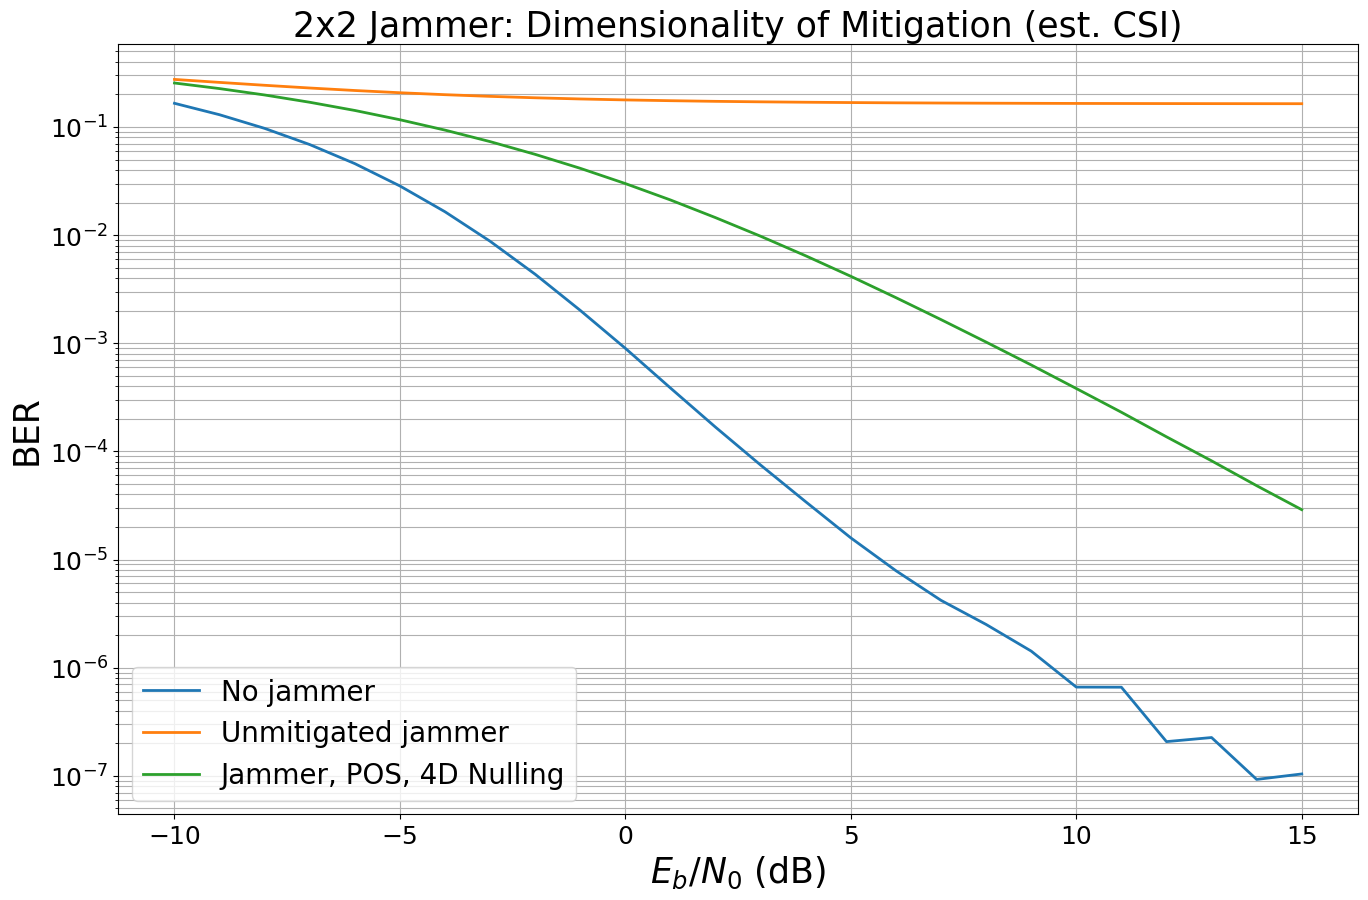

In [3]:
ber_plots.reset()
model_parameters = {}
jammer_parameters = {}
model_parameters["jammer_parameters"] = jammer_parameters

model_parameters["num_silent_pilot_symbols"] = 6
jammer_parameters["num_tx"] = 2
jammer_parameters["num_tx_ant"] = 2

model = Model(**model_parameters)
simulate_model(model, f"No jammer")

model_parameters["jammer_present"] = True
model = Model(**model_parameters)
simulate_model(model, f"Unmitigated jammer")

d = 4
model_parameters["jammer_mitigation"] = "pos"
model_parameters["jammer_mitigation_dimensionality"] = d
model = Model(**model_parameters)
simulate_model(model, f"Jammer, POS, {d}D Nulling")
    
ber_plots.title = "2x2 Jammer: Dimensionality of Mitigation (est. CSI)"
ber_plots()
with open("bers/paper/frequency/mitigation_dim.pickle", "wb") as f:
    pickle.dump(ber_plots, f)

In [4]:
# TODO change iterations
sim.MAX_MC_ITER = 3000
ber_plots.reset()
model_parameters = {}
jammer_parameters = {}
decoder_parameters={}
model_parameters["jammer_parameters"] = jammer_parameters
model_parameters["decoder_parameters"] = decoder_parameters

model_parameters["num_silent_pilot_symbols"] = 4
jammer_parameters["num_tx"] = 2
jammer_parameters["num_tx_ant"] = 2
model_parameters["coderate"] = 0.5
decoder_parameters["cn_type"] = "minsum"
decoder_parameters["num_iter"] = 20

model = Model(**model_parameters)
model._decoder.llr_max = 1000
simulate_model(model, f"No jammer", add_bler=True)

model_parameters["jammer_present"] = True
model = Model(**model_parameters)
model._decoder.llr_max = 1000
simulate_model(model, "Unmitigated jammer", add_bler=True)

d = 4
model_parameters["jammer_mitigation"] = "pos"
model_parameters["jammer_mitigation_dimensionality"] = d
model = Model(**model_parameters)
simulate_model(model, f"Jammer, POS, {d}D Nulling", add_bler=True)

ber_plots.title = "Different Decoder Parameters: 4UE, 0.5 coderate, 0dB Jammer"
ber_plots(show_ber=False)
with open("bers/paper/frequency/mitigation_bler.pickle", "wb") as f:
    pickle.dump(ber_plots, f)
sim.MAX_MC_ITER = 1500

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -10.0 | 2.5809e-01 | 1.0000e+00 |  1217828135 |  4718592000 |      1536000 |     1536000 |      1848.0 |reached max iter       
     -9.0 | 1.7305e-01 | 9.9598e-01 |   816552569 |  4718592000 |      1529822 |     1536000 |      1813.9 |reached max iter       
     -8.0 | 3.8537e-02 | 4.9508e-01 |   181842186 |  4718592000 |       760442 |     1536000 |      1830.0 |reached max iter       
     -7.0 | 6.9070e-03 | 1.0424e-01 |    32591355 |  4718592000 |       160113 |     1536000 |      1839.3 |reached max iter       


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -10.0 | 3.0320e-01 | 1.0000e+00 |      953778 |     3145728 |          512 |         512 |        10.1 |reached max iter       
   -7.222 | 2.4635e-01 | 1.0000e+00 |      774941 |     3145728 |          512 |         512 |         0.5 |reached max iter       
   -4.444 | 1.9878e-01 | 1.0000e+00 |      625311 |     3145728 |          512 |         512 |         0.5 |reached max iter       
   -1.667 | 1.6943e-01 | 1.0000e+00 |      532972 |     3145728 |          512 |         512 |         0.5 |reached max iter       
    1.111 | 1.5017e-01 | 1.0000e+00 |      472382 |     3145728 |          512 |         512 |         0.5 |reached max iter       
    3.889 | 1.4207e-01 | 1.0000e+00 |      446909 |     3145728 |          512 |     

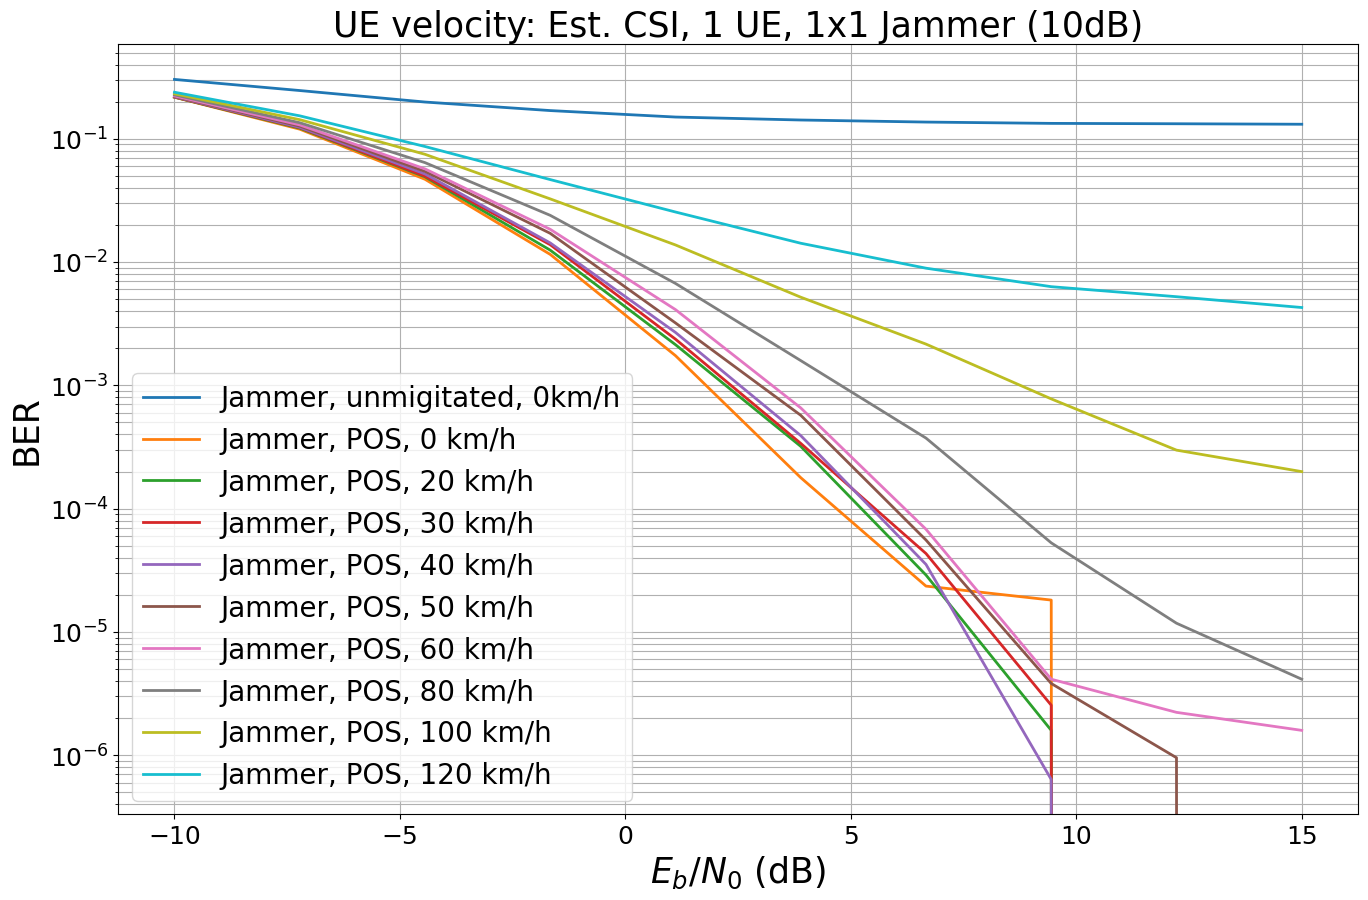

In [ ]:
ber_plots.reset()
model_parameters = {}
jammer_parameters = {}
model_parameters["jammer_parameters"] = jammer_parameters

model_parameters["num_silent_pilot_symbols"] = 4
model_parameters["jammer_present"] = True
model_parameters["jammer_power"] = db_to_linear(10.)

model = Model(**model_parameters)
simulate_model(model, "Jammer, unmigitated, 0km/h")

model_parameters["jammer_mitigation"] = "pos"
model_parameters["jammer_mitigation_dimensionality"] = 1
kmhs = [0, 20, 30, 40, 50, 60, 80, 100, 120]
for kmh in kmhs:
    meter_per_second = kmh / 3.6
    model_parameters["min_ut_velocity"] = meter_per_second
    model_parameters["max_ut_velocity"] = meter_per_second
    # model_parameters["min_jammer_velocity"] = meter_per_second
    # model_parameters["max_jammer_velocity"] = meter_per_second
    model = Model(**model_parameters)
    simulate_model(model, f"Jammer, POS, {kmh} km/h")

ber_plots.title = "UE velocity: Est. CSI, 1 UE, 1x1 Jammer (10dB)"
ber_plots()
with open("bers/paper/frequency/ut_velocity_mitigation.pickle", "wb") as f:
    pickle.dump(ber_plots, f)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -10.0 | 3.0227e-01 | 1.0000e+00 |      950859 |     3145728 |          512 |         512 |        10.0 |reached max iter       
   -7.222 | 2.4673e-01 | 1.0000e+00 |      776140 |     3145728 |          512 |         512 |         0.5 |reached max iter       
   -4.444 | 1.9921e-01 | 1.0000e+00 |      626645 |     3145728 |          512 |         512 |         0.5 |reached max iter       
   -1.667 | 1.6924e-01 | 1.0000e+00 |      532377 |     3145728 |          512 |         512 |         0.5 |reached max iter       
    1.111 | 1.5104e-01 | 1.0000e+00 |      475139 |     3145728 |          512 |         512 |         0.5 |reached max iter       
    3.889 | 1.4151e-01 | 1.0000e+00 |      445160 |     3145728 |          512 |     

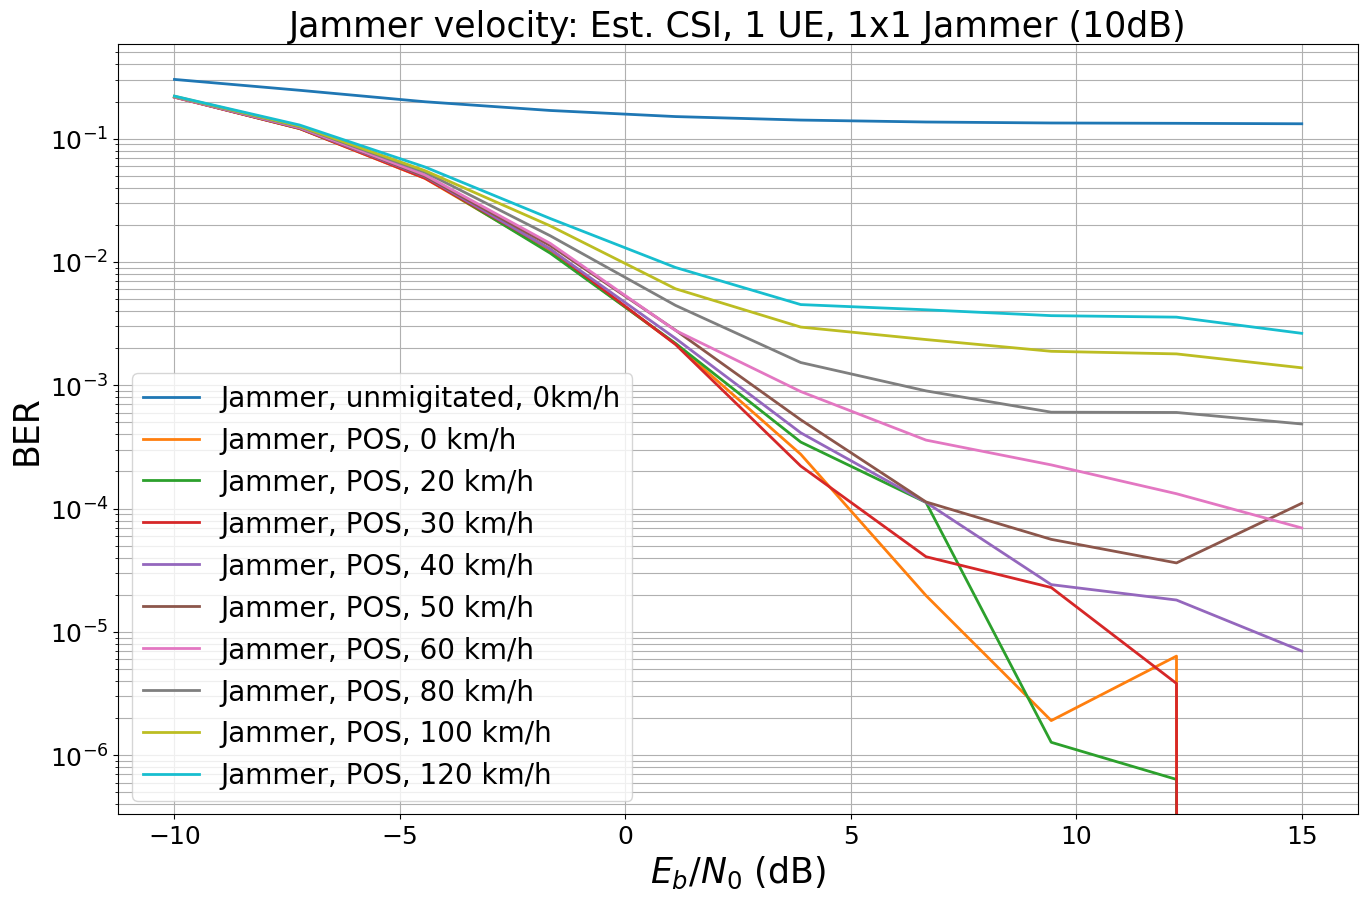

In [ ]:
ber_plots.reset()
model_parameters = {}
jammer_parameters = {}
model_parameters["jammer_parameters"] = jammer_parameters

model_parameters["num_silent_pilot_symbols"] = 4
model_parameters["jammer_present"] = True
model_parameters["jammer_power"] = db_to_linear(10.)

model = Model(**model_parameters)
simulate_model(model, "Jammer, unmigitated, 0km/h")

model_parameters["jammer_mitigation"] = "pos"
model_parameters["jammer_mitigation_dimensionality"] = 1
kmhs = [0, 20, 30, 40, 50, 60, 80, 100, 120]
for kmh in kmhs:
    meter_per_second = kmh / 3.6
    # model_parameters["min_ut_velocity"] = meter_per_second
    # model_parameters["max_ut_velocity"] = meter_per_second
    model_parameters["min_jammer_velocity"] = meter_per_second
    model_parameters["max_jammer_velocity"] = meter_per_second
    model = Model(**model_parameters)
    simulate_model(model, f"Jammer, POS, {kmh} km/h")

ber_plots.title = "Jammer velocity: Est. CSI, 1 UE, 1x1 Jammer (10dB)"
ber_plots()
with open("bers/paper/frequency/jammer_velocity_mitigation.pickle", "wb") as f:
    pickle.dump(ber_plots, f)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -10.0 | 3.8111e-01 | 1.0000e+00 |  1198856242 |  3145728000 |       512000 |      512000 |       607.0 |reached max iter       
     -9.0 | 3.6883e-01 | 1.0000e+00 |  1160243912 |  3145728000 |       512000 |      512000 |       577.6 |reached max iter       
     -8.0 | 3.5603e-01 | 1.0000e+00 |  1119958120 |  3145728000 |       512000 |      512000 |       576.2 |reached max iter       
     -7.0 | 3.4299e-01 | 1.0000e+00 |  1078950289 |  3145728000 |       512000 |      512000 |       577.0 |reached max iter       
     -6.0 | 3.3009e-01 | 1.0000e+00 |  1038373514 |  3145728000 |       512000 |      512000 |       577.9 |reached max iter       
     -5.0 | 3.1768e-01 | 1.0000e+00 |   999350300 |  3145728000 |       512000 |     

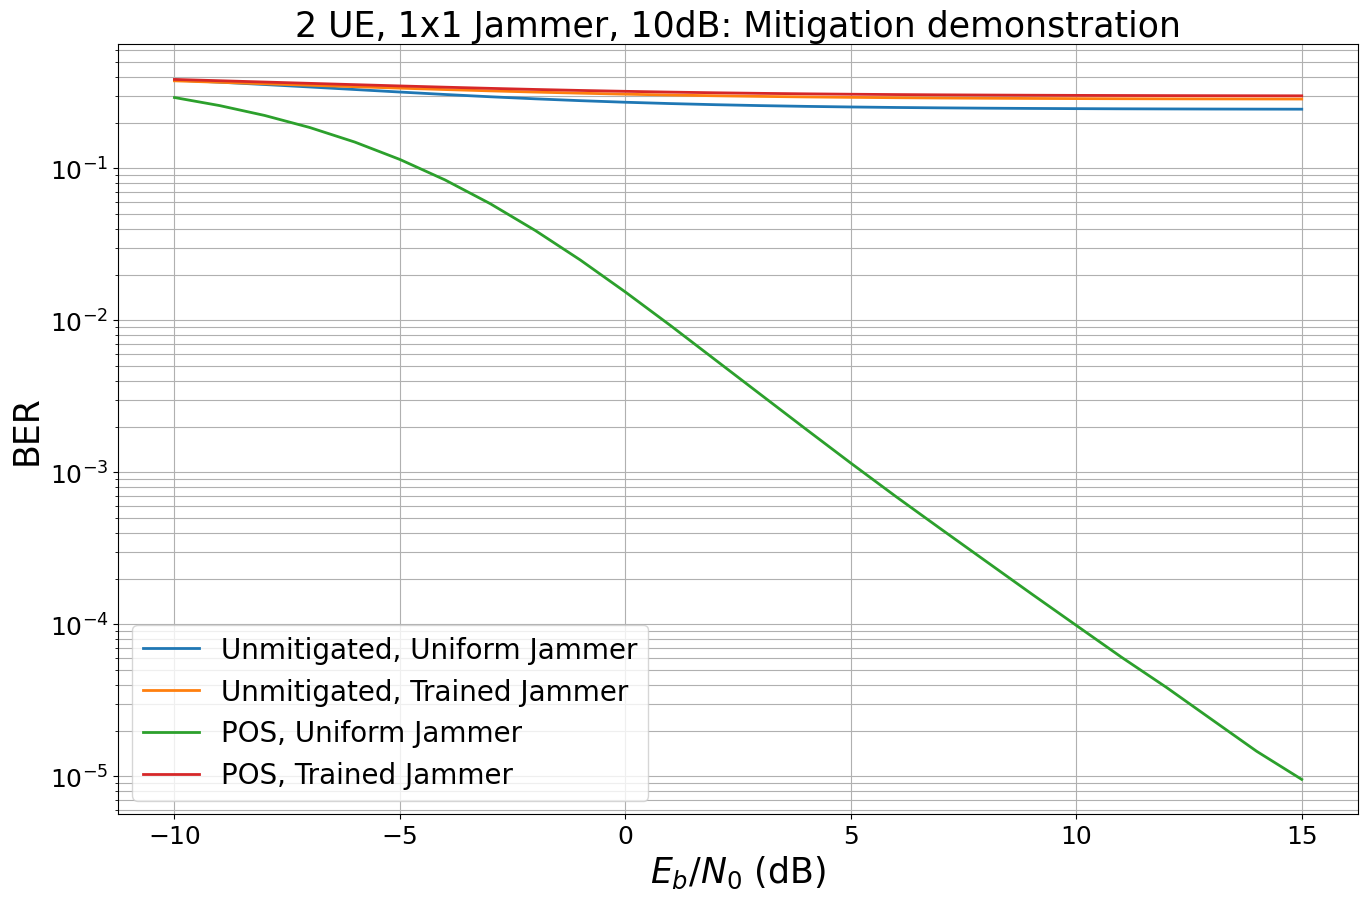

In [3]:
ber_plots.reset()
model_parameters = {}
jammer_parameters = {}
model_parameters["jammer_parameters"] = jammer_parameters

model_parameters["jammer_present"] = True
jammer_parameters["trainable"] = True
jammer_parameters["trainable_mask"] = tf.ones([14, 1], dtype=tf.bool)
model_parameters["num_ut"] = 2
model_parameters["jammer_power"] = db_to_linear(10.)

# unmitigated uniform
model_parameters["num_silent_pilot_symbols"] = 0
model = Model(**model_parameters)
simulate_model(model, "Unmitigated, Uniform Jammer")

# unmitigated trained
model = Model(**model_parameters)
load_weights(model, "weights/paper/unmitigated_ue_2_power_10.0dB.pickle")
simulate_model(model, "Unmitigated, Trained Jammer")

# pos uniform
model_parameters["num_silent_pilot_symbols"] = 2
model_parameters["jammer_mitigation"] = "pos"
model_parameters["jammer_mitigation_dimensionality"] = 1
model = Model(**model_parameters)
simulate_model(model, "POS, Uniform Jammer")

# pos trained
model = Model(**model_parameters)
load_weights(model, "weights/paper/pos_ue_2_power_10.0dB.pickle")
simulate_model(model, "POS, Trained Jammer")

ber_plots.title = "2 UE, 1x1 Jammer, 10dB: Mitigation demonstration"
ber_plots()
with open("bers/paper/learning/unmitigated_vs_pos.pickle", "wb") as f:
    pickle.dump(ber_plots, f)

In [2]:
model_parameters = {}
jammer_parameters = {}
model_parameters["jammer_parameters"] = jammer_parameters
model_parameters["jammer_present"] = True
jammer_parameters["trainable"] = True
jammer_parameters["trainable_mask"] = tf.ones([14, 1], dtype=tf.bool)

num_ut = range(1, 9)
jammer_power = np.arange(-5, 15.1, 5, dtype=np.float32)
for r in [1, 2]:
    bers = np.zeros([len(num_ut), len(jammer_power)])
    for i in range(len(num_ut)):
        for j in range(len(jammer_power)):
            n = num_ut[i]
            p = jammer_power[j]
            my_model_parameters = {**model_parameters, "num_ut": n, "jammer_power": db_to_linear(p),
                                   "num_ofdm_symbols": 14,
                                   "jammer_parameters": {**jammer_parameters, "trainable_mask": tf.ones([14, 1], dtype=tf.bool)}}
            # TODO add simulation run
            filename = f"weights/paper/grid_long/{r}/ue_{n}_power_{p}dB.pickle"
            model = Model(**my_model_parameters)
            load_weights(model, filename)
            ber = sionna.utils.BitErrorRate()
            for s in range(50):
                # BATCH_SIZE, ebno_db
                b, llr = model(128, 5.0)
                b_hat = sionna.utils.hard_decisions(llr)
                ber.update_state(b, b_hat)
            print(f"{n} UEs, {p} dB: {ber.result().numpy()}")
            bers[i, j] = ber.result().numpy()
    print(bers)
    with open(f"bers/paper/learning/grid_long_snrs_{r}.pickle", "wb") as f:
        pickle.dump(bers, f)

1 UEs, -5.0 dB: 0.09952645748853683
1 UEs, 0.0 dB: 0.30405333638191223
1 UEs, 5.0 dB: 0.4292111098766327
1 UEs, 10.0 dB: 0.4767078161239624
1 UEs, 15.0 dB: 0.492439329624176
2 UEs, -5.0 dB: 0.0488022118806839
2 UEs, 0.0 dB: 0.13158594071865082
2 UEs, 5.0 dB: 0.19637662172317505
2 UEs, 10.0 dB: 0.29395830631256104
2 UEs, 15.0 dB: 0.3728066384792328
3 UEs, -5.0 dB: 0.02309224382042885
3 UEs, 0.0 dB: 0.0729747787117958
3 UEs, 5.0 dB: 0.1370200216770172
3 UEs, 10.0 dB: 0.24281631410121918
3 UEs, 15.0 dB: 0.33628734946250916
4 UEs, -5.0 dB: 0.014077621512115002
4 UEs, 0.0 dB: 0.051444441080093384
4 UEs, 5.0 dB: 0.11506744474172592
4 UEs, 10.0 dB: 0.22097128629684448
4 UEs, 15.0 dB: 0.3189447522163391
5 UEs, -5.0 dB: 0.010304741561412811
5 UEs, 0.0 dB: 0.04585782811045647
5 UEs, 5.0 dB: 0.10881688445806503
5 UEs, 10.0 dB: 0.2142472118139267
5 UEs, 15.0 dB: 0.3127146363258362
6 UEs, -5.0 dB: 0.008640683256089687
6 UEs, 0.0 dB: 0.04227975383400917
6 UEs, 5.0 dB: 0.1117670089006424
6 UEs, 10.0 

In [4]:
model_parameters = {}
jammer_parameters = {}
model_parameters["jammer_parameters"] = jammer_parameters
model_parameters["jammer_present"] = True
jammer_parameters["trainable"] = False

num_ut = range(1, 9)
jammer_power = np.arange(-5, 15.1, 5, dtype=np.float32)
bers = np.zeros([len(num_ut), len(jammer_power)])
for i in range(len(num_ut)):
    for j in range(len(jammer_power)):
        n = num_ut[i]
        p = jammer_power[j]
        my_model_parameters = {**model_parameters, "num_ut": n, "jammer_power": db_to_linear(p),
                               "num_ofdm_symbols": 14,
                               "jammer_parameters": jammer_parameters}
        model = Model(**my_model_parameters)
        ber = sionna.utils.BitErrorRate()
        for s in range(50):
            # BATCH_SIZE, ebno_db
            b, llr = model(128, 5.0)
            b_hat = sionna.utils.hard_decisions(llr)
            ber.update_state(b, b_hat)
        print(f"{n} UEs, {p} dB: {ber.result().numpy()}")
        bers[i, j] = ber.result().numpy()
print(bers)
with open(f"bers/paper/learning/grid_snrs_uniform_jammer.pickle", "wb") as f:
    pickle.dump(bers, f)

1 UEs, -5.0 dB: 0.013844463974237442
1 UEs, 0.0 dB: 0.17666278779506683
1 UEs, 5.0 dB: 0.36926180124282837
1 UEs, 10.0 dB: 0.4554785192012787
1 UEs, 15.0 dB: 0.4854966998100281
2 UEs, -5.0 dB: 0.007793782744556665
2 UEs, 0.0 dB: 0.0793643444776535
2 UEs, 5.0 dB: 0.19683751463890076
2 UEs, 10.0 dB: 0.2620117962360382
2 UEs, 15.0 dB: 0.28626659512519836
3 UEs, -5.0 dB: 0.006701493635773659
3 UEs, 0.0 dB: 0.05244290456175804
3 UEs, 5.0 dB: 0.13302282989025116
3 UEs, 10.0 dB: 0.18322691321372986
3 UEs, 15.0 dB: 0.20310690999031067
4 UEs, -5.0 dB: 0.006596527062356472
4 UEs, 0.0 dB: 0.041761383414268494
4 UEs, 5.0 dB: 0.10294924676418304
4 UEs, 10.0 dB: 0.1427197903394699
4 UEs, 15.0 dB: 0.1589965969324112
5 UEs, -5.0 dB: 0.007033596280962229
5 UEs, 0.0 dB: 0.037654392421245575
5 UEs, 5.0 dB: 0.08733052760362625
5 UEs, 10.0 dB: 0.11992399394512177
5 UEs, 15.0 dB: 0.133695587515831
6 UEs, -5.0 dB: 0.007882118225097656
6 UEs, 0.0 dB: 0.036322299391031265
6 UEs, 5.0 dB: 0.07853370904922485
6 U